In [1]:
import numpy as np
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt 
import warnings
warnings.filterwarnings('ignore')

In [11]:
train = pd.read_csv('./data/input/salary_train.tsv', delimiter='\t')
test = pd.read_csv('./data/input/salary_test.tsv', delimiter='\t')

df_train = train.drop(columns='fnlwgt')
df_test = test.drop(columns='fnlwgt')

In [12]:
df_train.head()

,id,age,workclass,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,Y
0,5,90,Private,11th,7,Never-married,Handlers-cleaners,Own-child,White,Male,0,0,40,United-States,<=50K
1,10,46,Private,Assoc-acdm,12,Married-civ-spouse,Craft-repair,Husband,White,Male,0,1485,55,United-States,<=50K
2,11,37,Private,HS-grad,9,Married-civ-spouse,Adm-clerical,Wife,White,Female,0,0,40,United-States,>50K
3,13,45,Local-gov,Masters,14,Divorced,Prof-specialty,Unmarried,Black,Female,0,0,40,United-States,<=50K
4,14,40,Private,Assoc-acdm,12,Married-civ-spouse,Tech-support,Husband,White,Male,0,0,42,United-States,>50K


In [112]:
#train.info()

In [13]:
df_train.describe()

,id,age,education-num,capital-gain,capital-loss,hours-per-week
count,16280.000000,16280.000000,16280.000000,16280.000000,16280.000000,16280.000000
mean,16286.900921,38.603808,10.089558,1131.057617,88.075369,40.410012
std,9389.421853,13.672102,2.570911,7672.406043,405.251482,12.311716
min,5.000000,17.000000,1.000000,0.000000,0.000000,1.000000
25%,8169.500000,28.000000,9.000000,0.000000,0.000000,40.000000
50%,16267.500000,37.000000,10.000000,0.000000,0.000000,40.000000
75%,24458.250000,48.000000,12.000000,0.000000,0.000000,45.000000
max,32557.000000,90.000000,16.000000,99999.000000,4356.000000,99.000000


In [26]:
#test.info()

In [19]:
#EDA

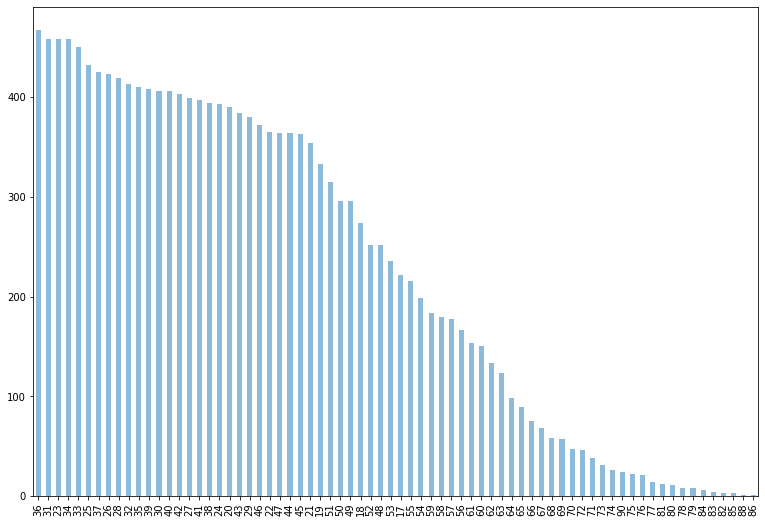

In [14]:
plt.figure(figsize=(13,9))
df_train['age'].value_counts().plot(kind='bar', alpha=0.5)

[Text(0, 0, 'Never-married'),
 Text(0, 0, 'Married-civ-spouse'),
 Text(0, 0, 'Married-civ-spouse'),
 Text(0, 0, 'Divorced'),
 Text(0, 0, 'Married-civ-spouse'),
 Text(0, 0, 'Married-civ-spouse'),
 Text(0, 0, 'Married-civ-spouse')]

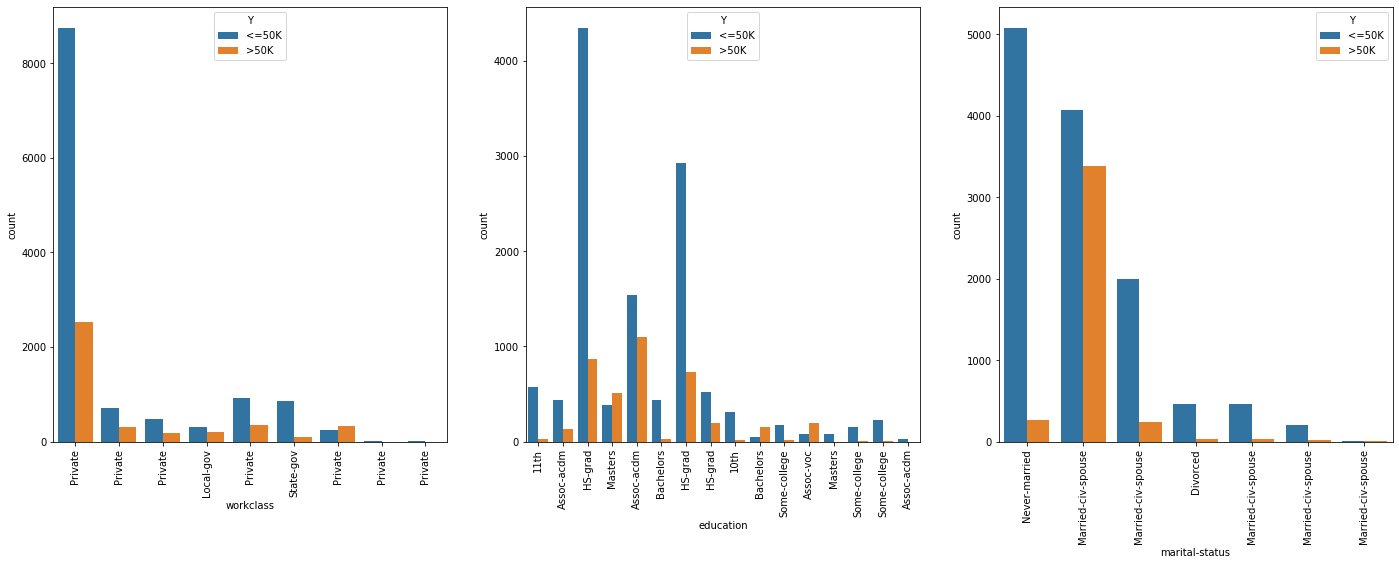

In [15]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(24,8))
sns.countplot(x='workclass', hue='Y', data=df_train, ax=ax1)
ax1.set_xticklabels(df_train.workclass , rotation=90)
sns.countplot(x='education', hue='Y', data=df_train, ax=ax2)
ax2.set_xticklabels(df_train.education , rotation=90)
sns.countplot(x='marital-status', hue='Y', data=df_train, ax=ax3)
ax3.set_xticklabels(df_train['marital-status'], rotation=90)

[Text(0, 0, 'White'),
 Text(0, 0, 'White'),
 Text(0, 0, 'White'),
 Text(0, 0, 'Black'),
 Text(0, 0, 'White')]

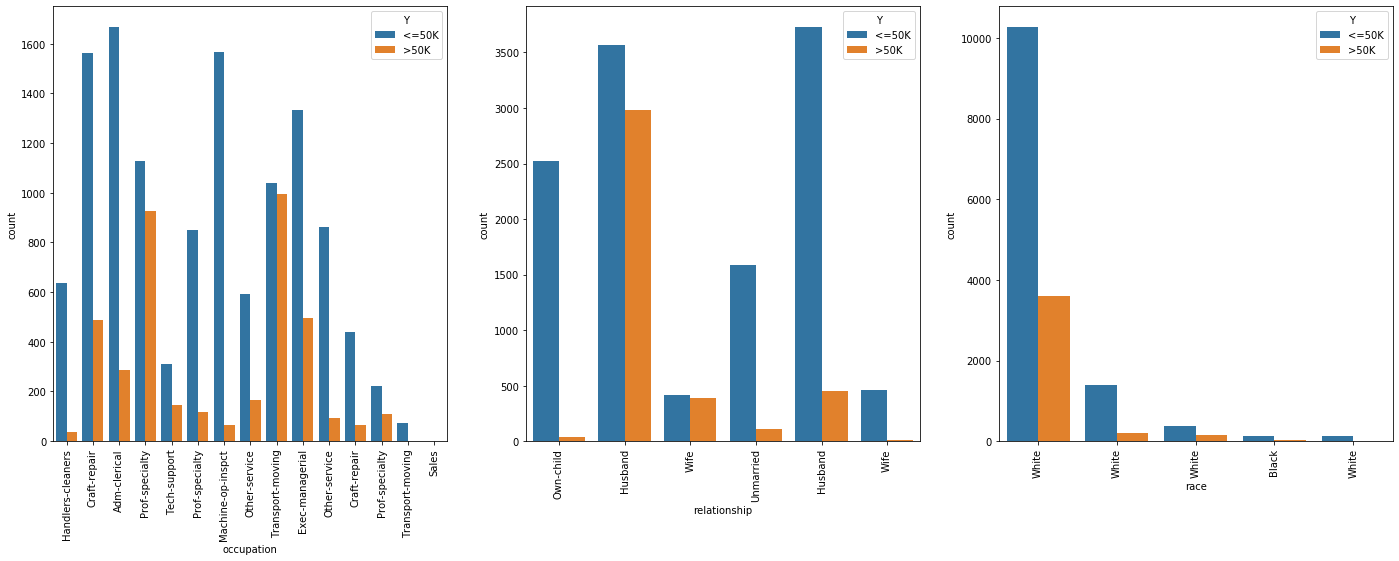

In [16]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(24,8))
sns.countplot(x='occupation', hue='Y', data=df_train, ax=ax1)
ax1.set_xticklabels(df_train.occupation , rotation=90)
sns.countplot(x='relationship', hue='Y', data=df_train, ax=ax2)
ax2.set_xticklabels(df_train.relationship , rotation=90)
sns.countplot(x='race', hue='Y', data=df_train, ax=ax3)
ax3.set_xticklabels(df_train.race, rotation=90)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 <a list of 15 Text xticklabel objects>)

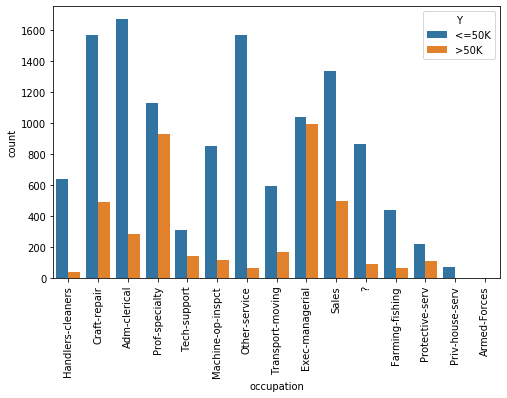

In [17]:
plt.figure(figsize=(8,5))
sns.countplot(x='occupation', hue='Y', data=df_train)
plt.xticks(rotation=90)

In [65]:
import pandas as pd 
import numpy as np

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, StratifiedKFold, GridSearchCV
from sklearn.metrics import log_loss, accuracy_score
import lightgbm as lgb 
import catboost as cat  
import xgboost as xgb 


train = pd.read_csv('./data/input/salary_train.tsv', delimiter='\t')
test = pd.read_csv('./data/input/salary_test.tsv', delimiter='\t')

df_train = train.drop(columns='fnlwgt')
df_test = test.drop(columns='fnlwgt')
df_train['mark'] = 'train'
df_test['mark'] = 'test'

all_data = pd.concat([df_train, df_test], axis=0)

#前処理
#キャピタルゲイン処理
all_data['capital'] = all_data['capital-gain'] * 1 + all_data['capital-loss'] * (-1)
capital_col = ['capital-gain', 'capital-loss']
for col in capital_col:
    all_data = all_data.drop(columns=col)

#LabelEncoding
le = LabelEncoder()
label_col = ['workclass', 'education', 'occupation', 'relationship', 'race', 'native-country', 'sex', 'marital-status']
for col in label_col:
    all_data[col] = le.fit_transform(all_data[col])

#目的変数エンコーディング
all_data = all_data.replace({'<=50K':0, '>50K':1})



# ------------------------------------------------------
# KFold分割
# ------------------------------------------------------
train_x = all_data[all_data['mark'] == 'train']
train_y = train_x['Y']
train_x = train_x.drop(columns=['Y', 'mark'])

test_x = all_data[all_data['mark'] == 'test']
test_x = test_x.drop(columns=['Y', 'mark'])



kf = KFold(n_splits=4, shuffle=True, random_state=71)
tr_idx, va_idx = list(kf.split(train_x))[0]

tr_x, va_x = train_x.iloc[tr_idx], train_x.iloc[va_idx]
tr_y, va_y = train_y.iloc[tr_idx], train_y.iloc[va_idx]

# ------------------------------------------------------
# xgboostの実装
# ------------------------------------------------------

scores = []

xgb_params = {
    'objective':'binary:logistic'
    , 'eval_metrics':'logloss'
}
num_round = 100 

dtrain = xgb.DMatrix(tr_x, label=tr_y)
dvalid = xgb.DMatrix(va_x, label=va_y)
dtest = xgb.DMatrix(test_x)

watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
bst = xgb.train(xgb_params, dtrain, num_boost_round=num_round, evals=watchlist)

va_pred = bst.predict(dvalid)
y_pred = np.where(va_pred > 0.5, 1, 0)
acc_score = accuracy_score(va_y, y_pred)
print(f'accuracy:{acc_score:.4f}')

pred = bst.predict(dtest)
pred_target = np.where(pred >= 0.5, '>50K', '<=50K')


pred_id = test_x['id']
pred_target = pd.DataFrame(pred_target, columns=['Y'])
submission_data = pd.concat([pred_id, pred_target], axis=1)



[0]	train-error:0.147993	eval-error:0.149877
[1]	train-error:0.144062	eval-error:0.144963
[2]	train-error:0.143735	eval-error:0.142998
[3]	train-error:0.141687	eval-error:0.140786
[4]	train-error:0.142424	eval-error:0.143735
[5]	train-error:0.141278	eval-error:0.143243
[6]	train-error:0.13317	eval-error:0.136364
[7]	train-error:0.133006	eval-error:0.136609
[8]	train-error:0.132596	eval-error:0.136364
[9]	train-error:0.13104	eval-error:0.135135
[10]	train-error:0.129812	eval-error:0.133907
[11]	train-error:0.128256	eval-error:0.133907
[12]	train-error:0.1276	eval-error:0.132924
[13]	train-error:0.126126	eval-error:0.134644
[14]	train-error:0.123751	eval-error:0.13317
[15]	train-error:0.123505	eval-error:0.135872
[16]	train-error:0.122768	eval-error:0.134152
[17]	train-error:0.122195	eval-error:0.133661
[18]	train-error:0.120066	eval-error:0.131204
[19]	train-error:0.120066	eval-error:0.131204
[20]	train-error:0.120229	eval-error:0.132678
[21]	train-error:0.119001	eval-error:0.134152
[22

In [67]:
submission_data.to_csv('./data/output/(20201107)_xgb.csv', index=False)

In [61]:
pred = bst.predict(dtest)
pred_target = np.where(pred >= 0.5, '>50K', '<=50K')


pred_id = test_x['id']
pred_target = pd.DataFrame(pred_target, columns=['Y'])
submission_data = pd.concat([pred_id, pred_target], axis=1)

In [71]:
import pandas as pd 
import numpy as np

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, StratifiedKFold, GridSearchCV
from sklearn.metrics import log_loss, accuracy_score
import lightgbm as lgb 
import catboost as cat  
import xgboost as xgb 

train = pd.read_csv('./data/input/salary_train.tsv', delimiter='\t')
test = pd.read_csv('./data/input/salary_test.tsv', delimiter='\t')

df_train = train.drop(columns='fnlwgt')
df_test = test.drop(columns='fnlwgt')
df_train['mark'] = 'train'
df_test['mark'] = 'test'

all_data = pd.concat([df_train, df_test], axis=0)

#train_x = df_train.drop('Y', axis=1)
#train_y = df_train['Y']


#前処理
#キャピタルゲイン処理
all_data['capital'] = all_data['capital-gain'] * 1 + all_data['capital-loss'] * (-1)
capital_col = ['capital-gain', 'capital-loss']
for col in capital_col:
    all_data = all_data.drop(columns=col)

#LabelEncoding
le = LabelEncoder()
label_col = ['workclass', 'education', 'occupation', 'relationship', 'race', 'native-country', 'sex', 'marital-status']
for col in label_col:
    all_data[col] = le.fit_transform(all_data[col])

#目的変数エンコーディング
all_data = all_data.replace({'<=50K':0, '>50K':1})



# ------------------------------------------------------
# KFold分割
# ------------------------------------------------------
train_x = all_data[all_data['mark'] == 'train']
train_y = train_x['Y']
train_x = train_x.drop(columns=['Y', 'mark'])

test_x = all_data[all_data['mark'] == 'test']
test_x = test_x.drop(columns=['Y', 'mark'])



kf = KFold(n_splits=4, shuffle=True, random_state=71)
tr_idx, va_idx = list(kf.split(train_x))[0]

tr_x, va_x = train_x.iloc[tr_idx], train_x.iloc[va_idx]
tr_y, va_y = train_y.iloc[tr_idx], train_y.iloc[va_idx]

# ------------------------------------------------------
# lightgbmの実装
# ------------------------------------------------------
lgb_train = lgb.Dataset(tr_x, tr_y)
lgb_eval = lgb.Dataset(va_x, va_y)

lgb_params = {
    'objective':'binary'
    , 'seed':71
    , 'verbose':0
    , 'metrics':'binary_logloss'
}
num_round = 100

bst = lgb.train(
    lgb_params
    , lgb_train
    , num_boost_round=num_round
    , valid_names=['train', 'valid']
    , valid_sets=[lgb_train, lgb_eval]
)

va_pred = bst.predict(va_x)
y_pred = np.where(va_pred>0.5, 1, 0)
acc_score = accuracy_score(va_y, y_pred)
print(f'acc_score:{acc_score:.4f}')

pred = bst.predict(test_x)
pred_target = np.where(pred >= 0.5, '>50K', '<=50K')


pred_id = test_x['id']
pred_target = pd.DataFrame(pred_target, columns=['Y'])
submission_data = pd.concat([pred_id, pred_target], axis=1)

#submission_data.to_csv('./data/input/(2020/11/7)_lgb.csv')

[1]	train's binary_logloss: 0.509844	valid's binary_logloss: 0.522961
[2]	train's binary_logloss: 0.477581	valid's binary_logloss: 0.489029
[3]	train's binary_logloss: 0.451953	valid's binary_logloss: 0.462611
[4]	train's binary_logloss: 0.431041	valid's binary_logloss: 0.440853
[5]	train's binary_logloss: 0.413481	valid's binary_logloss: 0.422846
[6]	train's binary_logloss: 0.398713	valid's binary_logloss: 0.40789
[7]	train's binary_logloss: 0.384932	valid's binary_logloss: 0.393876
[8]	train's binary_logloss: 0.373339	valid's binary_logloss: 0.38231
[9]	train's binary_logloss: 0.363347	valid's binary_logloss: 0.372502
[10]	train's binary_logloss: 0.354542	valid's binary_logloss: 0.363733
[11]	train's binary_logloss: 0.346823	valid's binary_logloss: 0.356234
[12]	train's binary_logloss: 0.339498	valid's binary_logloss: 0.349096
[13]	train's binary_logloss: 0.333235	valid's binary_logloss: 0.343285
[14]	train's binary_logloss: 0.327848	valid's binary_logloss: 0.338302
[15]	train's bina

In [75]:
submission_data.to_csv('./data/output/(2020-11-7)_lgb.csv', index=False)

In [172]:
cv_split = ShuffleSplit(n_splits=10, test_size=0.3, train_size=0.6, random_state=0)

MLA_columns = [
    'MLA name'
    ,'MLA Parameters'
    ,'MLA Train Accuracy Mean'
    ,'MLA Test Accuracy Mean'
    ,'MLA Time'
]

MLA_compare = pd.DataFrame(columns=MLA_columns)
MLA_predict = train_y.copy()

In [180]:
import pandas as pd 
import numpy as np

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, StratifiedKFold, GridSearchCV, ShuffleSplit, cross_validate
from sklearn.metrics import log_loss, accuracy_score
from bayes_opt import BayesianOptimization

from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.linear_model import LogisticRegressionCV, PassiveAggressiveClassifier, RidgeClassifierCV, SGDClassifier, Perceptron
from sklearn.naive_bayes import BernoulliNB, GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, NuSVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier


# ------------------------------------------------------
# データの前処理
# ------------------------------------------------------
train = pd.read_csv('../data/salary_train.tsv', delimiter='\t')
test = pd.read_csv('../data/salary_test.tsv', delimiter='\t')

df_train = train.drop(columns='fnlwgt')
df_test = test.drop(columns='fnlwgt')
df_train['mark'] = 'train'
df_test['mark'] = 'test'

all_data = pd.concat([df_train, df_test], axis=0).reset_index(drop=True)

#前処理
#キャピタルゲイン処理
all_data['capital'] = all_data['capital-gain'] * 1 + all_data['capital-loss'] * (-1)
capital_col = ['capital-gain', 'capital-loss']
for col in capital_col:
    all_data = all_data.drop(columns=col)

#LabelEncoding
le = LabelEncoder()
label_col = ['workclass', 'education', 'occupation', 'relationship', 'race', 'native-country', 'sex', 'marital-status']
for col in label_col:
    all_data[col] = le.fit_transform(all_data[col])

#目的変数エンコーディング
all_data = all_data.replace({'<=50K':0, '>50K':1})


#train data と test dataに分割
train_x = all_data[all_data['mark'] == 'train']
train_y = train_x['Y']
train_x = train_x.drop(columns=['Y', 'mark'])

test_x = all_data[all_data['mark'] == 'test']
test_x = test_x.drop(columns=['Y', 'mark'])


# ------------------------------------------------------
# 学習データ
# ------------------------------------------------------
MLA = [
    #Ensemble Methods
    AdaBoostClassifier()
    ,BaggingClassifier()
    ,ExtraTreeClassifier()
    ,GradientBoostingClassifier()
    ,RandomForestClassifier()

    #Gaussian Processes
    ,GaussianProcessClassifier()

    #GLM
    ,LogisticRegressionCV()
    ,PassiveAggressiveClassifier()
    ,RidgeClassifierCV()
    ,SGDClassifier()
    ,Perceptron()

    #Naive Bayes
    ,BernoulliNB()
    ,GaussianNB()

    #Nearest Neighbor
    ,KNeighborsClassifier()

    #SVM
    ,SVC(probability=True)
    ,LinearSVC()

    #Trees
    ,DecisionTreeClassifier()
    ,ExtraTreeClassifier()

    #Discriminant Analysis
    ,LinearDiscriminantAnalysis()
    ,QuadraticDiscriminantAnalysis()

    #xgboost
    ,XGBClassifier() 

    #lightgbm
    ,LGBMClassifier()
]

cv_split = ShuffleSplit(n_splits=10, test_size=0.3, train_size=0.6, random_state=0)

MLA_columns = [
    'MLA name'
    ,'MLA Parameters'
    ,'MLA Train Accuracy Mean'
    ,'MLA Test Accuracy Mean'
    ,'MLA Test Accuracy 3*STD'
    ,'MLA Time'
]

MLA_compare = pd.DataFrame(columns=MLA_columns)
MLA_predict = train_y.copy()


row_index = 0 
for alg in MLA:
    MLA_name = alg.__class__.__name__
    MLA_compare.loc[row_index, "MLA Name"] = MLA_name
    MLA_compare.loc[row_index, "MLA Parameters"] = str(alg.get_params())

    cv_results = cross_validate(alg, train_x, train_y, cv=cv_split, return_train_score=True)

    MLA_compare.loc[row_index, "MLA Time"] = cv_results["fit_time"].mean()
    MLA_compare.loc[row_index, "MLA Train Accuracy Mean"] = cv_results["train_score"].mean()
    MLA_compare.loc[row_index, "MLA Test Accuracy Mean"] = cv_results["test_score"].mean()
    MLA_compare.loc[row_index, "MLA Test Accuracy 3*STD"] = cv_results["test_score"].std()*3

    alg.fit(train_x, train_y)
    MLA_predict[MLA_name] = alg.predict(test_x)

    row_index += 1

In [181]:
MLA_compare 

,MLA name,MLA Parameters,MLA Train Accuracy Mean,MLA Test Accuracy Mean,MLA Test Accuracy 3*STD,MLA Time,MLA Name
0,NaN,"{'algorithm': 'SAMME.R', 'base_estimator': Non...",0.860289,0.857371,0.0154718,0.26689,AdaBoostClassifier
1,NaN,"{'base_estimator': None, 'bootstrap': True, 'b...",0.987111,0.839906,0.00980668,0.222434,BaggingClassifier
2,NaN,"{'ccp_alpha': 0.0, 'class_weight': None, 'crit...",1,0.7862,0.0208824,0.00725298,ExtraTreeClassifier
3,NaN,"{'ccp_alpha': 0.0, 'criterion': 'friedman_mse'...",0.870987,0.862101,0.0153077,0.913455,GradientBoostingClassifier
4,NaN,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",0.999959,0.848649,0.015033,0.800332,RandomForestClassifier
5,NaN,"{'copy_X_train': True, 'kernel': None, 'max_it...",1,0.687838,0.0126398,69.6228,GaussianProcessClassifier
6,NaN,"{'Cs': 10, 'class_weight': None, 'cv': None, '...",0.792701,0.791278,0.0210146,1.13479,LogisticRegressionCV
7,NaN,"{'C': 1.0, 'average': False, 'class_weight': N...",0.67545,0.678399,0.545648,0.015881,PassiveAggressiveClassifier
8,NaN,"{'alphas': array([ 0.1, 1. , 10. ]), 'class_w...",0.799754,0.800553,0.0188775,0.0136328,RidgeClassifierCV
9,NaN,"{'alpha': 0.0001, 'average': False, 'class_wei...",0.712152,0.711957,0.455374,0.159012,SGDClassifier
